# AI Exam

Consider the following environment:

<img src="images/road_env.jpg" style="zoom: 40%;"/>

The agent starts in cell $(0, 0)$ and must reach the goal in cell $(8,6)$. The agent can move in the four directions (except when a wall is present), and for each step taken the agent receives a negative reward.
In cells representing roads with intersections, the agent must wait for the traffic light to turn green before proceeding. At busy intersections (indicated by two traffic lights in the same cell), the agent will have to wait a long time to cross the intersection. This means that if the agent tries to move to another cell, the action may not succeed, causing the agent to remain in the same cell for an unknown amount of time.

Assume that you do not have access to the motion model and to reward and that the problem is undiscounted, find a solution for the environment reported above with a suitable algorithm of your choice, motivating your choice.

In [1]:
import os, sys 

module_path = os.path.abspath(os.path.join('tools'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gym, envs
from utils.ai_lab_functions import *
import numpy as np
from timeit import default_timer as timer
from tqdm import tqdm as tqdm

env_name = 'RoadEnv-v0'
env = gym.make(env_name)

env.render()

print("\nActions encoding: ", env.actions)

# Remember that you can know the type of a cell whenever you need by accessing the grid element of the environment:
print("Cell type of start state: ",env.grid[env.startstate])
print("Cell type of goal state: ",env.grid[env.goalstate])
state = 15 # a very busy intersection
print(f"Cell type of cell {env.state_to_pos(state)}: ",env.grid[state])
state = 10 # a less busy intersection
print(f"Cell type of cell {env.state_to_pos(state)}: ",env.grid[state])

# stampo delle informazioni agiuntive
print("\nReward of starting state:", env.RS[env.startstate])
print("Reward of goal state:", env.RS[env.goalstate])

print("\nSINGLE traffic light:")
current_state = env.pos_to_state(1, 1)
next_state = env.pos_to_state(2, 1)
print("Probability from (1, 1) to (2, 1) with action down: ", env.T[current_state, 3, next_state]) # probabilità di andare giù in caso di SINGOLO semaforo
print("Probability from (1, 1) to stay in (1, 1) with action down: ", env.T[current_state, 3, current_state]) # probabilità di andare su in caso di SINGOLO semaforo

print("\nDOUBLE traffic light:")
current_state = env.pos_to_state(1, 6)
next_state = env.pos_to_state(2, 6)
print("Probability from (1, 6) to (2, 6) with action down: ", env.T[current_state, 3, next_state]) # probabilità di andare giù in caso di DOPPIO semaforo
print("Probability from (1, 6) to stay in (1, 6) with action down: ", env.T[current_state, 3, current_state]) # probabilità di andare su in caso di DOPPIO semaforo


[['S' 'R' 'W' 'W' 'W' 'W' 'R' 'W' 'W']
 ['W' 'Ts' 'R' 'R' 'R' 'R' 'Tl' 'R' 'R']
 ['W' 'R' 'W' 'W' 'W' 'W' 'R' 'W' 'W']
 ['R' 'Ts' 'R' 'Ts' 'R' 'R' 'Ts' 'W' 'W']
 ['W' 'W' 'W' 'R' 'W' 'W' 'R' 'Ts' 'R']
 ['W' 'R' 'R' 'Tl' 'W' 'W' 'W' 'R' 'W']
 ['W' 'R' 'W' 'R' 'Ts' 'R' 'R' 'Tl' 'R']
 ['W' 'R' 'W' 'W' 'R' 'W' 'W' 'R' 'W']
 ['R' 'Ts' 'R' 'R' 'Tl' 'R' 'G' 'Ts' 'R']]

Actions encoding:  {0: 'L', 1: 'R', 2: 'U', 3: 'D'}
Cell type of start state:  S
Cell type of goal state:  G
Cell type of cell (1, 6):  Tl
Cell type of cell (1, 1):  Ts

Reward of starting state: -0.04
Reward of goal state: 5.0

SINGLE traffic light:
Probability from (1, 1) to (2, 1) with action down:  0.8
Probability from (1, 1) to stay in (1, 1) with action down:  0.2

DOUBLE traffic light:
Probability from (1, 6) to (2, 6) with action down:  0.2
Probability from (1, 6) to stay in (1, 6) with action down:  0.8


In [2]:
# Value Iteration [MDP] che non può però essere utilizzato
def value_iteration(environment, maxiters=300, discount=0.9, max_error=1e-3):
    
    U_1 = [0 for _ in range(environment.observation_space.n)] # vector of utilities for states S
    delta = 0 # maximum change in the utility o any state in an iteration
    U = U_1.copy()

    iteration = 0
    stop = False

    while (not stop):
        iteration += 1
        U = U_1.copy()
        delta = 0

        for state in range(0,environment.observation_space.n):
            # controllo se si tratta di uno stato terminale
            if environment.grid[state] == "P" or environment.grid[state] == "G":
                U_1[state] = environment.RS[state]
            else:
                maxCalcolo = 0 # massimale
                for action in range(0,environment.action_space.n): # cilco su tutte le possibili azioni
                    res = 0
                    for next_state in range(0,environment.observation_space.n): # ciclo per tutti i possibili stati successori
                        res += environment.T[state, action, next_state] * U[next_state]
                    # calcolo il massimale
                    maxCalcolo = max(maxCalcolo, res)

                U_1[state] = environment.RS[state] + discount * maxCalcolo

            if abs(U_1[state] - U[state]) > delta:
                delta = abs(U_1[state] - U[state])

        stop = (delta < (max_error * (1 - discount)/discount)) or (iteration > maxiters)
    
    print("Iterazioni: ", iteration)
    print("Delta: ", delta)

    return values_to_policy(np.asarray(U), environment) # automatically convert the value matrix U to a policy

Implemento le funzioni "epsilon_greedy" e "softmax" per poter poi utilizzarle negli algoritmi di *Q-learning* e *SARSA*.

Uso questi due algoritmi perché nella consegna è specificato che l'ambiente è **undiscounted** e di conseguenza non è permesso utilizzare un algoritmo MDP *(come Value Iteration)* visto che utilizza una vaiabile di dicount.

In [3]:
def epsilon_greedy(q, state, epsilon):

    if np.random.random() < epsilon: #enters the if only if the random number is less than epsilon (i.e., with probability  epsilon)
        return np.random.choice(q.shape[1]) #the size of first dimension of q is number of states, the second is number of actions 
    return q[state].argmax() #q[state] is a vector of q-values indexed by actions

def softmax(q, state, temp):
    e = np.exp(q[state] / temp) #a vector indexed by action where each value is e^(q(s,a)/T)
    return np.random.choice(q.shape[1], p=e / e.sum()) # choose an action with probability e^(q(s,a)/T)/sum_{a'} e^(q(s,a')/T)  

Implemento l'algoritmo ***Q-learning*** visto a laboratorio:

In [4]:
def q_learning(environment, episodes, alpha, gamma, expl_func, expl_param):
    
    q = np.zeros((environment.observation_space.n, environment.action_space.n))  # Q(s, a)
    rews = np.zeros(episodes)
    lengths = np.zeros(episodes)

    for i in range(episodes):
        # resetto l'ambiente alla posizione iniziale (stato iniziale)
        state = environment.reset()
        stop = False 

        while(not stop):
            action = expl_func(q, state, expl_param)
            
            next_state, reward, done, _ = environment.step(action)

            q[state][action] = q[state][action] + alpha * (reward + gamma*max(q[next_state, :]) - q[state][action])

            state = next_state

            # aggiorno il conteggio dei reward e la lunghezza dell'episodio
            rews[i] += reward
            lengths[i] += 1
            stop = done
              
    policy = q.argmax(axis=1) # q.argmax(axis=1) automatically extract the policy from the q table
    return policy, rews, lengths # mi serve solo la policy come output

Implemento l'algoritmo ***SARSA***:

In [5]:
def sarsa(environment, episodes, alpha, gamma, expl_func, expl_param):
    q = np.zeros((environment.observation_space.n, environment.action_space.n))  # Q(s, a)
    rews = np.zeros(episodes)
    lengths = np.zeros(episodes)

    for i in range(episodes):
        # resetto l'ambiente alla posizione iniziale (stato iniziale)
        state = environment.reset()
        action = expl_func(q, state, expl_param)
        stop = False 

        while(not stop):
            next_state, reward, stop, _ = environment.step(action)
            next_action = expl_func(q, next_state, expl_param)

            q[state][action] = q[state][action] + alpha * (reward + gamma*q[next_state, next_action] - q[state][action])

            state = next_state
            action = next_action

            # aggiorno il conteggio dei reward e la lunghezza dell'episodio
            rews[i] += reward
            lengths[i] += 1
              
    policy = q.argmax(axis=1) # q.argmax(axis=1) automatically extract the policy from the q table
    return policy, rews, lengths

In [6]:
#IMPLEMENT THIS FUNCTION, YOU CAN CHANGE THE PARAMETERS FOR THE FUNCTION IF THIS IS USEFUL
def my_solution(environment): 
    # uso gli stessi parametri usati a lezione
    episodes = 500
    alpha = .3
    gamma = .9
    epsilon = .1

    policy = value_iteration(environment)
    # policy, rewards, lenght = q_learning(environment, episodes, alpha, gamma, epsilon_greedy, epsilon)
    # policy, rewards, lenght = sarsa(environment, episodes, alpha, gamma, epsilon_greedy, epsilon)
    
    return policy

    # return np.random.choice(environment.action_space.n,environment.observation_space.n)

#### CONFRONTO TRA I DUE ALGORITMI SARSA E Q-LEARNING

Come da lezione di laboratorio, confrontiamo l'esecuzione di una serie di episodi svolti usando l'algoritmo di Q-learning e SARSA.

Execution time: 1.2381s


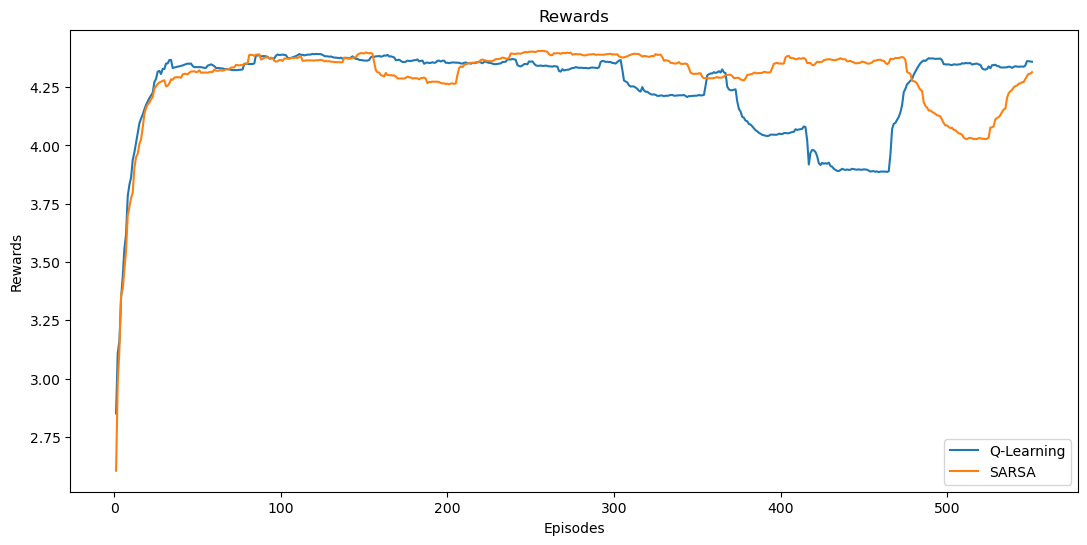

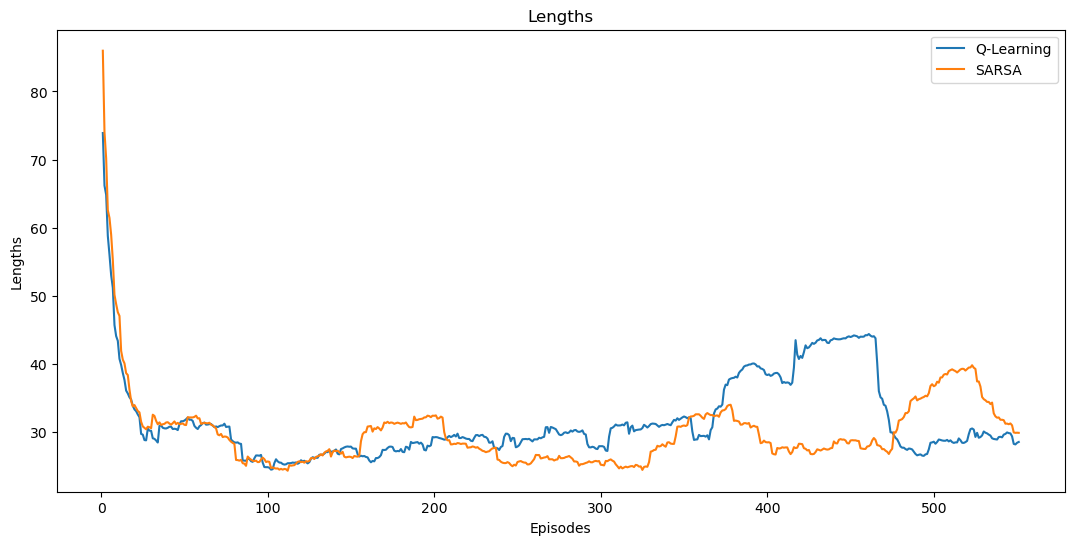

In [7]:
# Learning parameters
episodes = 600
ep_limit = 50
alpha = .3
gamma = .9
epsilon = .1
temp = 1

rewser = []
lenser = []

litres = np.arange(1, episodes + 1)  # Learning iteration values
window = 50  # Rolling window

t = timer()

# Q-Learning
_, rews, lengths = q_learning(env, episodes, alpha, gamma, epsilon_greedy, epsilon)
# _, rews, lengths = q_learning(env, episodes, alpha, gamma, softmax, temp)
rews = rolling(rews, window)
rewser.append({"x": np.arange(1, len(rews) + 1), "y": rews, "ls": "-", "label": "Q-Learning"})
lengths = rolling(lengths, window)
lenser.append({"x": np.arange(1, len(lengths) + 1), "y": lengths, "ls": "-", "label": "Q-Learning"})

# SARSA
_, rews, lengths = sarsa(env, episodes, alpha, gamma, epsilon_greedy, epsilon)
#_, rews, lengths = q_learning(env, episodes, alpha, gamma, softmax, temp)
rews = rolling(rews, window)
rewser.append({"x": np.arange(1, len(rews) + 1), "y": rews, "label": "SARSA"})
lengths = rolling(lengths, window)
lenser.append({"x": np.arange(1, len(lengths) + 1), "y": lengths, "label": "SARSA"})

print("Execution time: {0}s".format(round(timer() - t, 4)))

# Rewards
plot(rewser, "Rewards", "Episodes", "Rewards")
# Lunghezze
plot(lenser, "Lengths", "Episodes", "Lengths")

## Soluzione Effettiva

In [8]:
t = timer()

solution = my_solution(env)
print(f"Execution time: {round(timer() - t, 4)}s\n") 
solution_render = np.vectorize(env.actions.get)(solution.reshape(env.shape))
print(solution_render)

Iterazioni:  43
Delta:  9.883706117230773e-05
Execution time: 0.3118s

[['R' 'D' 'L' 'L' 'L' 'L' 'D' 'L' 'L']
 ['L' 'D' 'L' 'R' 'R' 'R' 'D' 'L' 'L']
 ['L' 'D' 'L' 'L' 'L' 'L' 'D' 'L' 'L']
 ['R' 'R' 'R' 'R' 'R' 'R' 'D' 'L' 'L']
 ['L' 'L' 'L' 'D' 'L' 'L' 'R' 'D' 'L']
 ['L' 'D' 'L' 'D' 'L' 'L' 'L' 'D' 'L']
 ['L' 'D' 'L' 'R' 'D' 'L' 'R' 'D' 'L']
 ['L' 'D' 'L' 'L' 'D' 'L' 'L' 'D' 'L']
 ['R' 'R' 'R' 'R' 'R' 'R' 'L' 'L' 'L']]
